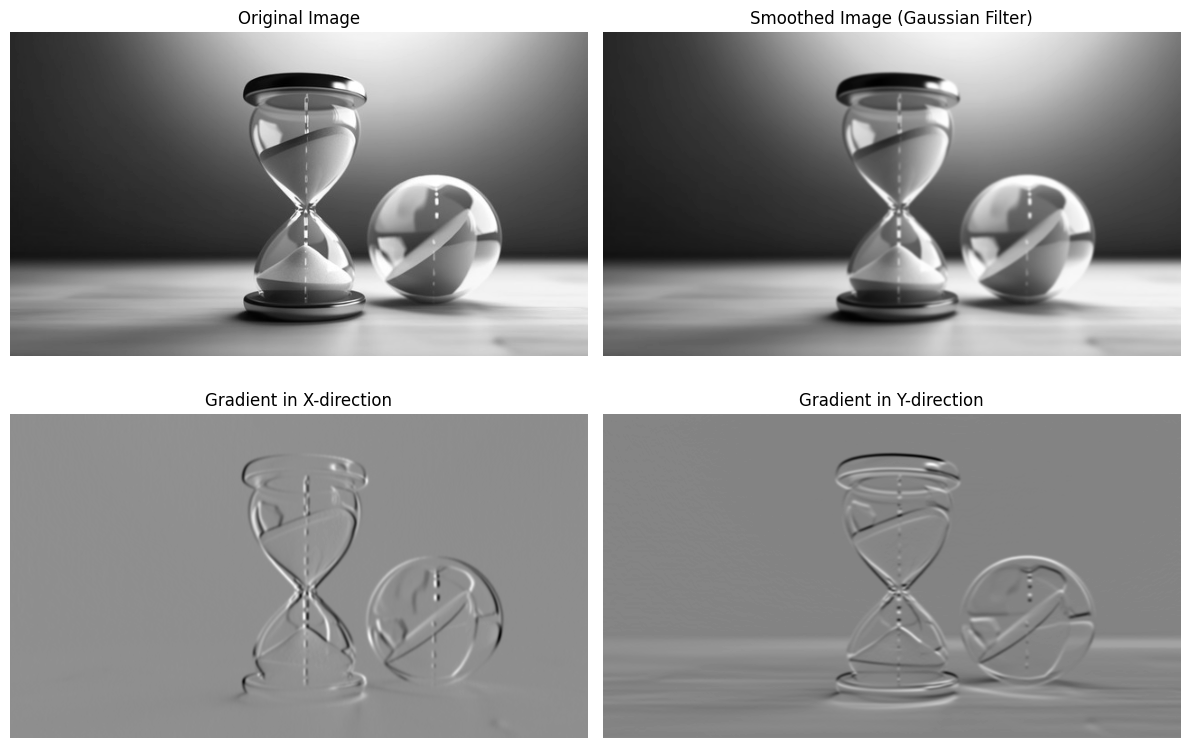

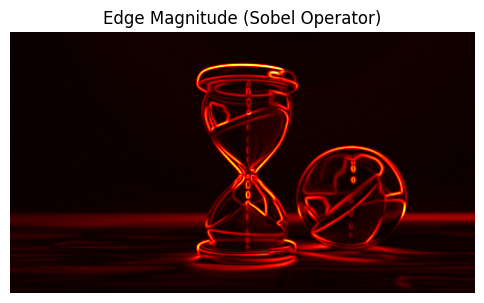

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = r'image_path'  # Replace with your image path
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Check if the image is loaded
if image is None:
    print("Error: Image not loaded. Please check the file path.")
else:
    # Step 1: Apply Gaussian smoothing to reduce noise
    smoothed_image = cv2.GaussianBlur(image, (5, 5), 0)

    # Step 2: Compute the gradient in the x-direction using Sobel operator
    grad_x = cv2.Sobel(smoothed_image, cv2.CV_64F, 1, 0, ksize=3)

    # Step 3: Compute the gradient in the y-direction using Sobel operator
    grad_y = cv2.Sobel(smoothed_image, cv2.CV_64F, 0, 1, ksize=3)

    # Step 4: Compute the magnitude of gradients
    magnitude = cv2.magnitude(grad_x, grad_y)

    # Step 5: Normalize the magnitude to display
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)

    # Display results
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1), plt.imshow(image, cmap='gray'), plt.title('Original Image'), plt.axis('off')
    plt.subplot(2, 2, 2), plt.imshow(smoothed_image, cmap='gray'), plt.title('Smoothed Image (Gaussian Filter)'), plt.axis('off')
    plt.subplot(2, 2, 3), plt.imshow(grad_x, cmap='gray'), plt.title('Gradient in X-direction'), plt.axis('off')
    plt.subplot(2, 2, 4), plt.imshow(grad_y, cmap='gray'), plt.title('Gradient in Y-direction'), plt.axis('off')
    plt.tight_layout()

    # Display the magnitude of edges
    plt.figure(figsize=(6, 6))
    plt.imshow(magnitude, cmap='hot')
    plt.title('Edge Magnitude (Sobel Operator)')
    plt.axis('off')
    plt.show()


Number of training images: 1027
Number of testing images: 256


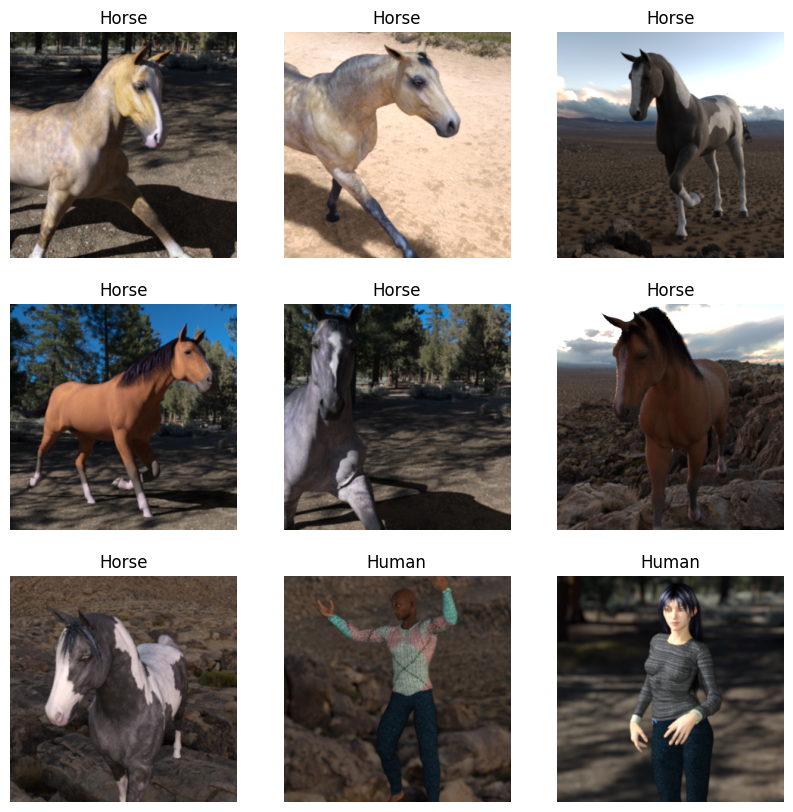

Epoch 1/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.5240 - loss: 0.6893 - val_accuracy: 0.8398 - val_loss: 0.5164
Epoch 2/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 28s 867ms/step - accuracy: 0.6561 - loss: 0.6304 - val_accuracy: 0.8320 - val_loss: 0.4478
Epoch 3/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 29s 891ms/step - accuracy: 0.7050 - loss: 0.5929 - val_accuracy: 0.8398 - val_loss: 0.3863
Epoch 4/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 30s 917ms/step - accuracy: 0.7338 - loss: 0.5558 - val_accuracy: 0.8594 - val_loss: 0.3464
Epoch 5/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 30s 912ms/step - accuracy: 0.7687 - loss: 0.5200 - val_accuracy: 0.8516 - val_loss: 0.3347


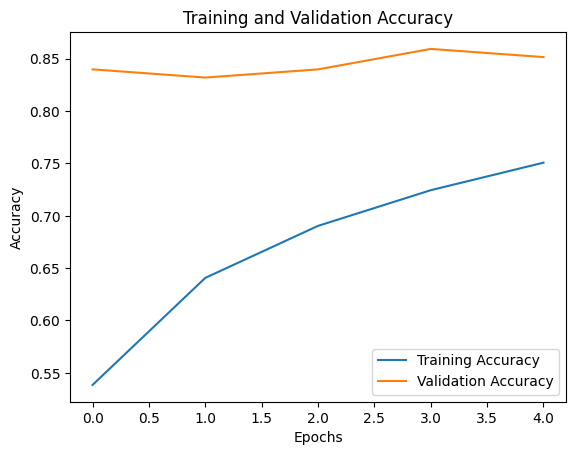

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 720ms/step - accuracy: 0.8744 - loss: 0.2996
Test accuracy: 0.8515625


In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

# 1. Load the dataset
(ds_train, ds_test), ds_info = tfds.load('horses_or_humans', split=['train', 'test'], with_info=True, as_supervised=True)

# 2. View the number of testing and training images
train_size = ds_info.splits['train'].num_examples
test_size = ds_info.splits['test'].num_examples
print(f"Number of training images: {train_size}")
print(f"Number of testing images: {test_size}")

# 3. Plot some images
def plot_samples(dataset, num_images=9):
    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(dataset.take(num_images)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title("Horse" if label == 0 else "Human")
    plt.show()

# Display first 9 images from the training dataset
plot_samples(ds_train)

# 4. Normalizing the training data and preprocessing the dataset
def preprocess_data(dataset, batch_size=32):
    def normalize_image(image, label):
        image = tf.image.resize(image, (128, 128))  # Resize images to 128x128
        image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values to [0, 1]
        return image, label

    return dataset.map(normalize_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_ds = preprocess_data(ds_train)
test_ds = preprocess_data(ds_test)

# 5. Build a Convolutional Neural Network (ResNet) for classification
base_model = tf.keras.applications.ResNet50(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the ResNet layers

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary classification (horse or human)
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 6. Train the CNN model and show the accuracy
history = model.fit(train_ds, epochs=5, validation_data=test_ds)

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# 7. Show the testing accuracy
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc}")
